#Set Up

In [ ]:
!pip install torchprofile 1>/dev/null
!pip install fast-pytorch-kmeans 1>/dev/null

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/food_product_main

In [ ]:
import torchvision.transforms as transforms
import torchvision
import glob
import os
import torch
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import DataLoader

import random
from collections import OrderedDict, defaultdict

import numpy as np
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from tqdm.auto import tqdm
from torchprofile import profile_macs

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

##Dataset

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize((0, 0, 0), (255, 255, 255))
])

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(root='food_product_main', transform=transform)

In [ ]:
# Open the text file in read mode
with open('/content/drive/MyDrive/product_label.txt', 'r') as file:
    # Read all lines from the file and store them as a list
    lines = file.readlines()

# Strip newline characters from the end of each line and store them in a new list
class_set = sorted([line.strip() for line in lines])
print(class_set)

['bada_coconut_original', 'banana_choco_pie', 'bichobi_biscuit', 'binch', 'busor_busor_bulgogi', 'butter_waffle', 'chic_choc_chocolate_cookie', 'choco_hazelnut', 'choco_pie_orion', 'choripong_mushmellow', 'cookie_dasse', 'couque_dasse', 'crown_corn_chip', 'crown_cracker', 'custard_real_cream', 'digest_thin', 'dolaon_sun', 'enaak_chicken', 'gu_on_potato', 'homerun_ball', 'honey_butter_chip', 'hureswi_berry_fresh', 'kobuk_chip_mini', 'kokal_corn', 'korae_bab', 'lotte_choco', 'lotte_choco_abc_cookie', 'lotte_sand_original', 'lotte_teok_pie', 'maccaret_original', 'memorie_donut', 'mini_apple_cookie', 'mu_dukduk_potato', 'nongshim_shrimp_chip', 'nongshim_shrimp_chip_hot', 'nooneul_potato', 'oh_yes_mini', 'omma_sun_pie', 'onion_ring_original', 'oreo_stick_choco', 'peanut_sand', 'phokha_chip_onion', 'phokha_chip_original', 'postick', 'slim_potato_chip', 'strawberry_cookie', 'swing_chip_garlic', 'swing_chip_hot', 'tacco', 'white_hazelnut']


In [ ]:
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.transform = transform
        self.image_paths = []
        for ext in ['png', 'jpg']:
            self.image_paths += glob.glob(os.path.join(root_dir, '*', f'*.{ext}'))
        self.class_lbl = { cls: i for i, cls in enumerate(class_set)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = read_image(self.image_paths[idx], ImageReadMode.RGB).float()
        # img = Image.open(self.image_paths[idx]).convert('RGB')
        cls = os.path.basename(os.path.dirname(self.image_paths[idx]))
        label = self.class_lbl[cls]

        return self.transform(img), torch.tensor(label)

In [ ]:
train_set = CustomDataset('food_product_main/train', transform)
test_set = CustomDataset('food_product_main/test', transform)
print(train_set.image_paths)

['food_product_main/train/swing_chip_garlic/20240106173448_1212101108_0_1.png', 'food_product_main/train/swing_chip_garlic/20240206123029_1213974355_0_1.png', 'food_product_main/train/swing_chip_garlic/20240205205018_1213940109_0_1.png', 'food_product_main/train/swing_chip_garlic/20231201230305_1210013968_0_1.png', 'food_product_main/train/swing_chip_garlic/20240217151048_1214498872_0_1.png', 'food_product_main/train/swing_chip_garlic/20240111165707_1212407428_0_1.png', 'food_product_main/train/kobuk_chip_mini/images-65.jpg', 'food_product_main/train/kobuk_chip_mini/images-46.jpg', 'food_product_main/train/kobuk_chip_mini/images-213.jpg', 'food_product_main/train/kobuk_chip_mini/images-74.jpg', 'food_product_main/train/kobuk_chip_mini/images-446.jpg', 'food_product_main/train/kobuk_chip_mini/images-12.jpg', 'food_product_main/train/kobuk_chip_mini/images-163.jpg', 'food_product_main/train/kobuk_chip_mini/images-45.jpg', 'food_product_main/train/kobuk_chip_mini/images-78.jpg', 'food_pro

In [ ]:
print(len(train_set))
print(len(test_set))

6000
1500


In [ ]:
dataloaders = {
    "train": DataLoader(train_set, batch_size=8, shuffle=True),
    "test": DataLoader(test_set, batch_size=8, shuffle=False)
}

print(dataloaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7d735d4cd7b0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7d735d4cf0d0>}


In [ ]:
for inputs, targets in dataloaders["train"]:
  print("[inputs] dtype: {}, shape: {}".format(inputs.dtype, inputs.shape))
  print("[targets] dtype: {}, shape: {}".format(targets.dtype, targets.shape))
  break

[inputs] dtype: torch.float32, shape: torch.Size([8, 3, 128, 128])
[targets] dtype: torch.int64, shape: torch.Size([8])


##Model

In [ ]:
import torch.nn.functional as F

class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, len(class_set))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.backbone(x)
    x = x.mean([2, 3])
    x = self.classifier(x)
    probabilities = F.softmax(x, dim=1)  # Apply softmax activation to convert logits to probabilities
    confidence_percentages = probabilities * 100     # Convert probabilities to percentages

    return confidence_percentages

model = VGG().cuda()

In [ ]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements

def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [ ]:
print(model.backbone)
print(model.classifier)

Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

#Model Training

In [ ]:
def train(
  model: nn.Module,
  dataflow: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
) -> None:
  model.train()

  for inputs, targets in tqdm(dataflow, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

In [ ]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataflow: DataLoader,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataflow, desc="eval", leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = Adam(
  model.parameters(),
  lr=0.01
)

# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

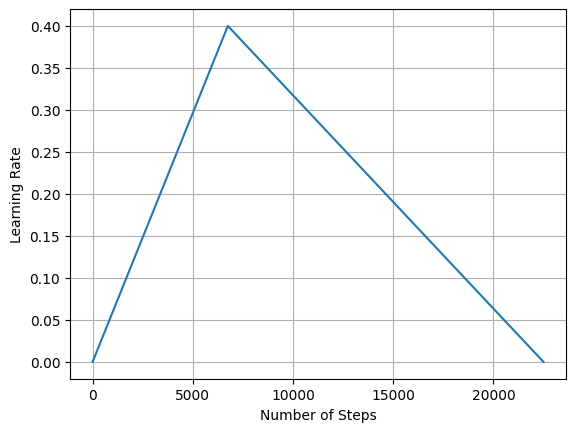

In [ ]:
num_epochs = 30
steps_per_epoch = len(dataloaders["train"])

# Define the piecewise linear scheduler
lr_lambda = lambda step: np.interp(
  [step / steps_per_epoch],
  [0, num_epochs * 0.3, num_epochs],
  [0, 1, 0]
)[0]

# Visualize the learning rate schedule
steps = np.arange(steps_per_epoch * num_epochs)
plt.plot(steps, [lr_lambda(step) * 0.4 for step in steps])
plt.xlabel("Number of Steps")
plt.ylabel("Learning Rate")
plt.grid("on")
plt.show()

scheduler = LambdaLR(optimizer, lr_lambda)

In [ ]:
for epoch_num in tqdm(range(1, num_epochs + 1)):
  train(model, dataloaders["train"], criterion, optimizer, scheduler)
  metric = evaluate(model, dataloaders["test"])
  print(f"epoch {epoch_num}:", metric)

torch.save(model.state_dict(), 'checkpoint_03.pth')

  0%|          | 0/30 [00:00<?, ?it/s]

train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 1: 7.066666126251221


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 2: 28.266664505004883


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 3: 41.93333435058594


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 4: 50.13333511352539


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 5: 46.53333282470703


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 6: 62.93333053588867


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 7: 58.20000076293945


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 8: 46.866668701171875


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 9: 41.666664123535156


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 10: 73.33333587646484


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 11: 65.20000457763672


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 12: 62.599998474121094


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 13: 84.0


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 14: 87.66666412353516


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 15: 89.53333282470703


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 16: 89.86666870117188


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 17: 90.73332977294922


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 18: 89.53333282470703


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 19: 91.86666870117188


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 20: 92.66666412353516


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 21: 91.13333129882812


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 22: 91.53333282470703


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 23: 93.4000015258789


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 24: 95.13333129882812


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 25: 95.19999694824219


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 26: 96.0


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 27: 95.9333267211914


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 28: 96.13333129882812


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 29: 96.93333435058594


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

epoch 30: 96.80000305175781


##Visualization

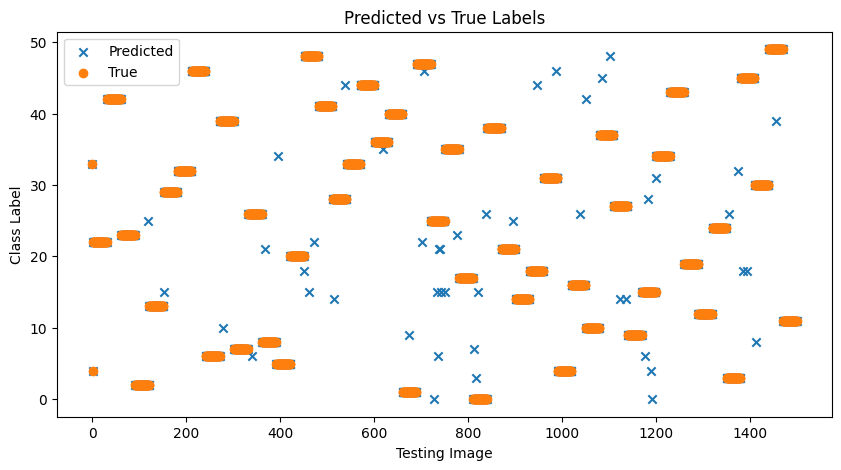

Accuracy: 96.87%


In [ ]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Create a list to store predicted and true labels
predicted_labels = []
true_labels = []

# Iterate over the validation set
for inputs, targets in test_set:
    # Move inputs to GPU if available
    inputs = inputs.cuda()

    # Perform inference
    with torch.no_grad():
        outputs = model(inputs.unsqueeze(0))  # Add batch dimension
        predicted_label = outputs.argmax(dim=1).item()

    # Append predicted and true labels to the list
    predicted_labels.append(predicted_label)
    true_labels.append(targets)

# Convert predicted and true labels to numpy arrays
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

# Visualize the predictions
plt.figure(figsize=(10, 5))
plt.scatter(range(len(predicted_labels)), predicted_labels, label='Predicted', marker='x')
plt.scatter(range(len(true_labels)), true_labels, label='True', marker='o')
plt.xlabel('Testing Image')
plt.ylabel('Class Label')
plt.title('Predicted vs True Labels')
plt.legend()
plt.show()

# Calculate accuracy
accuracy = (predicted_labels == true_labels).mean()

print(f"Accuracy: {accuracy:.2%}")

#Model Channel Pruning

##Model Checkpoint

In [ ]:
import copy

checkpoint_path = "/content/checkpoint.pth" ## modify this to checkpoint path
checkpoint = torch.load(checkpoint_path, map_location="cpu")
model = VGG().cuda()
model.load_state_dict(checkpoint)
recover_model = lambda: model.load_state_dict(checkpoint)

In [ ]:
dense_model_accuracy = evaluate(model, dataloaders["test"])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

eval:   0%|          | 0/188 [00:00<?, ?it/s]

dense model has accuracy=96.80%
dense model has size=35.28 MiB


##Train & Evaluate Functions

In [ ]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [ ]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

##Pruning

In [ ]:
# function to sort the channels from important to non-important
def get_input_channel_importance(weight):
    in_channels = weight.shape[1]
    importances = []
    for i_c in range(weight.shape[1]):
        channel_weight = weight.detach()[:, i_c]
        importance = torch.norm(channel_weight)
        importances.append(importance.view(1))
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model):
    model = copy.deepcopy(model)

    # fetch all the conv and bn layers from the backbone
    conv_layers = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    bn_layers = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]

    # iterate through conv layers
    for i in range(len(conv_layers) - 1):
        prev_conv = conv_layers[i]
        prev_bn = bn_layers[i]
        next_conv = conv_layers[i + 1]
        # compute the importance of each input channel (e.g., based on magnitude of weights)
        importance = get_input_channel_importance(next_conv.weight)
        # sorting importance from large to small
        sorted_indices = importance.argsort(descending=True)

        # apply to previous conv and its following bn
        prev_conv.weight.copy_(torch.index_select(
            prev_conv.weight.detach(), 0, sorted_indices))
        for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
            tensor_to_apply = getattr(prev_bn, tensor_name)
            tensor_to_apply.copy_(
                torch.index_select(tensor_to_apply.detach(), 0, sorted_indices)
            )

        # apply to the next conv input
        next_conv.weight.copy_(
            torch.index_select(next_conv.weight.detach(), 1, sorted_indices)
        )
    return model

In [ ]:
from typing import List, Union

def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    return int(round(channels * (1 - prune_ratio)))

@torch.no_grad()
def channel_prune(model: nn.Module,
                  prune_ratio: Union[List, float]) -> nn.Module:
    # sanity check of provided prune_ratio
    assert isinstance(prune_ratio, (float, list))
    n_conv = len([m for m in model.backbone if isinstance(m, nn.Conv2d)])
    # note that for the ratios, it affects the previous conv output and next
    # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:  # convert float to list
        prune_ratio = [prune_ratio] * (n_conv - 1)

    # we prune the convs in the backbone with a uniform ratio
    model = copy.deepcopy(model)  # prevent overwrite

    # we only apply pruning to the backbone features
    conv_layers = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    bn_layers = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]

    # apply pruning. we naively keep the first k channels
    assert len(conv_layers) == len(bn_layers)
    for i_ratio, p_ratio in enumerate(prune_ratio):
        prev_conv = conv_layers[i_ratio]
        prev_bn = bn_layers[i_ratio]
        next_conv = conv_layers[i_ratio + 1]
        original_channels = prev_conv.out_channels  # same as next_conv.in_channels
        n_keep = get_num_channels_to_keep(original_channels, p_ratio)

        # prune the output of the previous conv and bn
        prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
        prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
        prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
        prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
        prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])

        # prune the input of the next conv (hint: just one line of code)
        next_conv.weight.set_(next_conv.weight.detach()[:, :n_keep])
    return model

In [ ]:
channel_pruning_ratio = 0.5

print(" * Without sorting...")
pruned_model = channel_prune(model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloaders['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


print(" * With sorting...")
sorted_model = apply_channel_sorting(model)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloaders['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

 * Without sorting...


eval:   0%|          | 0/188 [00:00<?, ?it/s]

pruned model has accuracy=2.47%
 * With sorting...


eval:   0%|          | 0/188 [00:00<?, ?it/s]

pruned model has accuracy=18.07%


##Fine-tuning

In [ ]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0
for epoch in range(num_finetune_epochs):
    train(pruned_model, dataloaders['train'], criterion, optimizer, scheduler)
    accuracy = evaluate(pruned_model, dataloaders['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_accuracy = accuracy
    print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1 Accuracy 93.73% / Best Accuracy: 93.73%


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2 Accuracy 96.07% / Best Accuracy: 96.07%


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3 Accuracy 95.93% / Best Accuracy: 96.07%


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4 Accuracy 95.80% / Best Accuracy: 96.07%


train:   0%|          | 0/750 [00:00<?, ?it/s]

eval:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5 Accuracy 95.87% / Best Accuracy: 96.07%


In [ ]:
torch.save(pruned_model.state_dict(), 'checkpoint_channel_pruning.pth')

##Checking Latency

In [ ]:
import time

@torch.no_grad()
def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
    model.eval()
    # warmup
    for _ in range(n_warmup):
        _ = model(dummy_input)
    # real test
    t1 = time.time()
    for _ in range(n_test):
        _ = model(dummy_input)
    t2 = time.time()
    return (t2 - t1) / n_test  # average latency

table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. measure the latency of the original model and the pruned model on CPU
#   which simulates inference on an edge device
dummy_input = torch.randn(1, 3, 32, 32).to('cpu')
pruned_model = pruned_model.to('cpu')
model = model.to('cpu')

pruned_latency = measure_latency(pruned_model, dummy_input)
original_latency = measure_latency(model, dummy_input)
print(table_template.format('Latency (ms)',
                            round(original_latency * 1000, 1),
                            round(pruned_latency * 1000, 1),
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = get_model_macs(model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)',
                            round(original_macs / 1e6),
                            round(pruned_macs / 1e6),
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = get_num_parameters(model)
pruned_param = get_num_parameters(pruned_model)
print(table_template.format('Param (M)',
                            round(original_param / 1e6, 2),
                            round(pruned_param / 1e6, 2),
                            round(original_param / pruned_param, 1)))

# put model back to cuda
pruned_model = pruned_model.to('cuda')
model = model.to('cuda')

                Original        Pruned          Reduction Ratio
Latency (ms)    26.7            8.4             3.2            
MACs (M)        606             162             3.8            
Param (M)       9.25            2.92            3.2            


In [ ]:
# Double Check
file_size = os.path.getsize('/content/checkpoint_channel_pruning.pth')
print(f"The size of the saved pruned model file is: {file_size / (1024 * 1024):.2f} MiB")

#Convertion to TFLite

In [ ]:
!pip install onnx
!pip install onnx_tf

import torch
import torchvision.models as models
import torchvision.transforms as transforms
import onnx
from onnx_tf.backend import prepare
import tensorflow as tf

In [ ]:
import torch.nn.functional as F

class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
  # ARCH = [32, 64, 'M', 128, 128, 'M', 256, 256, 'M', 256, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, len(class_set))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.backbone(x)
    x = x.mean([2, 3])
    x = self.classifier(x)
    probabilities = F.softmax(x, dim=1)  # Apply softmax activation to convert logits to probabilities
    confidence_percentages = probabilities * 100     # Convert probabilities to percentages

    return confidence_percentages

In [ ]:
# Load the VGG model from the checkpoint
checkpoint_path = "checkpoint_channel_pruning.pth"
checkpoint = torch.load(checkpoint_path, map_location="cpu")
model = VGG()
model.load_state_dict(checkpoint)
model.eval()

# Define a sample input shape for the model
input_shape = (8, 3, 128, 128)

# Create a dummy input tensor with the defined shape
dummy_input = torch.randn(input_shape)

# Export the PyTorch model to ONNX format
onnx_path = "model.onnx"
torch.onnx.export(model,
                  dummy_input,
                  onnx_path,
                  input_names=['input'],   # Input tensor name (arbitary)
                  output_names=['output'] # Output tensor name (arbitary) verbose=True)
                  )

In [ ]:
# Load the ONNX model
model = onnx.load("model.onnx")

# Check that the IR is well formed
onnx.checker.check_model(model)

# Print a Human readable representation of the graph
onnx.helper.printable_graph(model.graph)

'graph main_graph (\n  %input[FLOAT, 8x3x128x128]\n) initializers (\n  %classifier.weight[FLOAT, 50x512]\n  %classifier.bias[FLOAT, 50]\n  %onnx::Conv_85[FLOAT, 64x3x3x3]\n  %onnx::Conv_86[FLOAT, 64]\n  %onnx::Conv_88[FLOAT, 128x64x3x3]\n  %onnx::Conv_89[FLOAT, 128]\n  %onnx::Conv_91[FLOAT, 256x128x3x3]\n  %onnx::Conv_92[FLOAT, 256]\n  %onnx::Conv_94[FLOAT, 256x256x3x3]\n  %onnx::Conv_95[FLOAT, 256]\n  %onnx::Conv_97[FLOAT, 512x256x3x3]\n  %onnx::Conv_98[FLOAT, 512]\n  %onnx::Conv_100[FLOAT, 512x512x3x3]\n  %onnx::Conv_101[FLOAT, 512]\n  %onnx::Conv_103[FLOAT, 512x512x3x3]\n  %onnx::Conv_104[FLOAT, 512]\n  %onnx::Conv_106[FLOAT, 512x512x3x3]\n  %onnx::Conv_107[FLOAT, 512]\n) {\n  %/backbone/conv0/Conv_output_0 = Conv[dilations = [1, 1], group = 1, kernel_shape = [3, 3], pads = [1, 1, 1, 1], strides = [1, 1]](%input, %onnx::Conv_85, %onnx::Conv_86)\n  %/backbone/relu0/Relu_output_0 = Relu(%/backbone/conv0/Conv_output_0)\n  %/backbone/conv1/Conv_output_0 = Conv[dilations = [1, 1], group 

In [ ]:
import onnx
from onnx_tf.backend import prepare

In [ ]:
onnx_model = "model.onnx"
output_model = "model_tf.pb"  # TensorFlow model output file

onnx_model = onnx.load(onnx_model)
tf_rep = prepare(onnx_model)
tf_rep.export_graph(output_model)

INFO:absl:Function `__call__` contains input name(s) x, y with unsupported characters which will be renamed to transpose_32_x, add_7_y in the SavedModel.
INFO:absl:Found untraced functions such as gen_tensor_dict while saving (showing 1 of 1). These functions will not be directly callable after loading.
INFO:absl:Writing fingerprint to model_tf.pb/fingerprint.pb


In [ ]:
# Convert the model
tflite_model_path = 'model_channel_pruning.tflite'
tf_model_path = 'model_tf.pb'
converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
tflite_model = converter.convert()

# Save the model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

#Model Inference Testing

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="model_channel_pruning.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details[0]['shape'])
print(output_details[0]['shape'])
print(input_details)

[  8   3 128 128]
[ 8 50]
[{'name': 'serving_default_input:0', 'index': 0, 'shape': array([  8,   3, 128, 128], dtype=int32), 'shape_signature': array([  8,   3, 128, 128], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [17]:
# Load and preprocess the image
image_path = "/content/f29f697d-e928-4b73-b43b-0f7333b81e34.jpg"
image = Image.open(image_path)
image = image.resize((input_details[0]['shape'][2], input_details[0]['shape'][3]))
image = np.array(image, dtype=np.float32) / 255 # Normalize pixel values to [0, 1]

image = np.array([image for i in range(8)])
image = np.transpose(image, (0, 3, 1, 2))

index = input_details[0]['index']

# Set input tensor
interpreter.set_tensor(index, image)

# Perform inference
interpreter.invoke()

In [18]:
# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
# print(output_data[0][2])
predicted_class = np.argmax(output_data)
# print(predicted_class)

# Load labels (if available)
labels = None
labels_path = 'product_label.txt'  # Replace with your label file path
if labels_path:
    with open(labels_path, 'r') as f:
        labels = [line.strip() for line in f.readlines()]

# Post-process inference results
top_classes = output_data[0].argsort()[-5:][::-1]  # Get top 5 classes with highest scores

# Print detected objects and confidence scores
for class_id in top_classes:
    confidence = output_data[0][class_id]
    probabilities = (np.exp(confidence) / np.sum(np.exp(output_data[0]))) * 100
    print("Class: {} - Confidence: {:} - Percentage: {:.2f}%".format(labels[class_id], confidence, probabilities))

Class: tacco - Confidence: 41.797176361083984 - Percentage: 100.00%
Class: chic_choc_chocolate_cookie - Confidence: 7.594037055969238 - Percentage: 0.00%
Class: nongshim_shrimp_chip - Confidence: 6.517587661743164 - Percentage: 0.00%
Class: kobuk_chip_mini - Confidence: 4.528082370758057 - Percentage: 0.00%
Class: banana_choco_pie - Confidence: 3.9245169162750244 - Percentage: 0.00%
